<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

In [2]:
torch.device('cuda:0')

device(type='cuda', index=0)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [ ]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

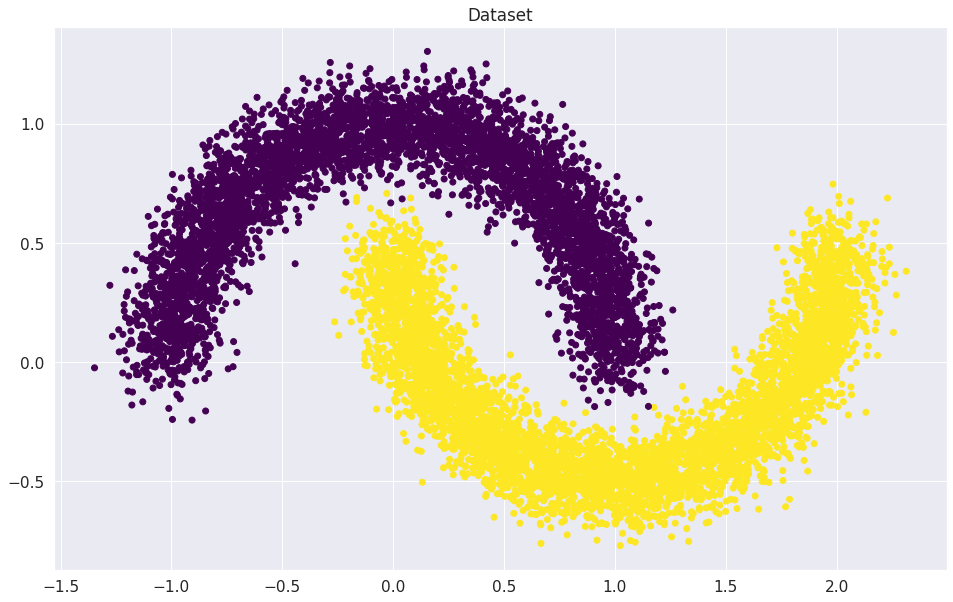

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [ ]:
X_train_t =  torch.from_numpy(X_train) # YOUR CODE GOES HERE
y_train_t =  torch.from_numpy(y_train) # YOUR CODE GOES HERE
X_val_t =  torch.from_numpy(X_val) # YOUR CODE GOES HERE
y_val_t =  torch.from_numpy(y_val) # YOUR CODE GOES HERE

Создаем `Dataset` и `DataLoader`. 

In [ ]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [ ]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features).double()) #nn.Parameter уже включает в себя requires_grad=True
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.empty(out_features).double(), requires_grad=True) # YOUR CODE GOES HERE

    def forward(self, x):
        x = x @ self.weights # YOUR CODE GOES HERE
        
        if self.bias:
            x += self.bias_term # YOUR CODE GOES HERE
        return x

In [ ]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели?

In [ ]:
sum(p.numel() for p in linear_regression.parameters() if p.requires_grad)
#YOUR CODE

3

Проверка связи:

In [ ]:
data = torch.tensor([3, 2], dtype=torch.double)
linear_regression.forward(data)

tensor([-1.8863], dtype=torch.float64, grad_fn=<AddBackward0>)

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [ ]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression.forward(X_batch) # YOUR CODE. Use linear_regression to get outputs
        y_batch = y_batch.unsqueeze(1).double()
        loss = loss_function(outp, y_batch)  # YOUR CODE. Compute loss
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = torch.exp(outp) / torch.exp(outp).sum(dim=1, keepdims=True) # YOUR CODE. Compute probabilities
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if it % 500000 == 0:
            print(f"Iteration: {it + epoch*len(train_dataset)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch*len(train_dataset)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 62.0
Iteration: 7500
Batch accuracy: 62.0
Iteration: 15000
Batch accuracy: 62.0
Iteration: 22500
Batch accuracy: 62.0
Iteration: 30000
Batch accuracy: 62.0
Iteration: 37500
Batch accuracy: 62.0
Iteration: 45000
Batch accuracy: 62.0
Iteration: 52500
Batch accuracy: 62.0
Iteration: 60000
Batch accuracy: 62.0
Iteration: 67500
Batch accuracy: 62.0
Iteration: 75000
Batch accuracy: 62.0
Iteration: 82500
Batch accuracy: 62.0
Iteration: 90000
Batch accuracy: 62.0

Iteration: 90047.Convergence. Stopping iterations.


**Вопрос 2.**

Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:**

Iteration: 90047.Convergence. Stopping iterations.

### Визуализируем результаты

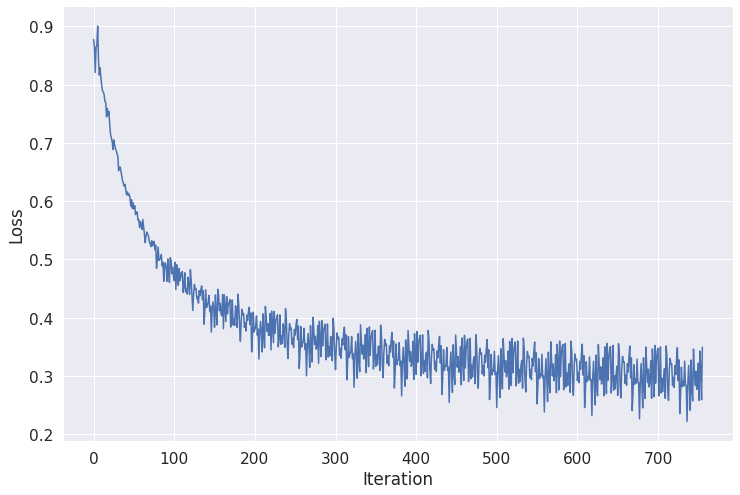

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

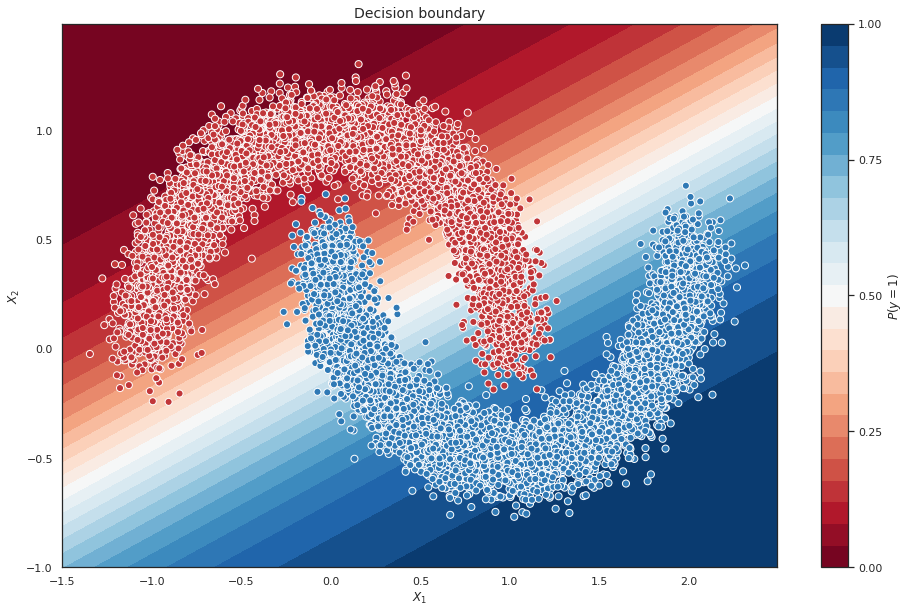

In [ ]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.double)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch)).reshape(xx.shape)
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [ ]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp = model(x_batch) 
        probs = torch.sigmoid(outp)
        preds = (probs > 0.5).type(torch.long) #YOUR CODE. Compute predictions
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [ ]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_val_t, predict(val_dataloader, linear_regression))
print(acc) # YOUR CODE. Compute total accuracy

0.8672


**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 

0.8672

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [3]:
import os
from torchvision.datasets import MNIST
import torchvision.transforms as tfs

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader =  torch.utils.data.DataLoader(train_dataset, batch_size=128,
                                          shuffle=True, num_workers=2)
valid_dataloader =  torch.utils.data.DataLoader(val_dataset, batch_size=128,
                                         shuffle=False, num_workers=2)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [16]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [17]:
activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10)   #YOUR CODE. Add layers to your sequential class
)

In [18]:
criterion = nn.CrossEntropyLoss() #YOUR CODE. Select loss function
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [19]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    correct = 0
    epoch_correct = 0
    epoch_all = 0
    for k, dataloader in loaders.items():
        for x_batch, y_batch in dataloader:
            #x_batch.to(device)
            #y_batch.to(device)
            if k == "train":
              model.train()
              optimizer.zero_grad() 
              outp = model(x_batch)
              loss = criterion(outp, y_batch)
                 # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
            else:
              model.eval()
              with torch.no_grad():
                outp = model(x_batch)
                 # YOUR CODE. Set model to ``eval`` mode and calculate outputs
            preds = outp.argmax(-1)
            correct = (preds==y_batch).cpu().numpy().sum() # YOUR CODE GOES HERE
            all = np.sum(list(y_batch.size())) # YOUR CODE GOES HERE
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward() 
                optimizer.step() # YOUR CODE. Calculate gradients and make a step of your optimizer
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.8877333333333334
Loader: valid. Accuracy: 0.8953857142857143
Epoch: 2
Loader: train. Accuracy: 0.9483333333333334
Loader: valid. Accuracy: 0.9495285714285714
Epoch: 3
Loader: train. Accuracy: 0.9647166666666667
Loader: valid. Accuracy: 0.965
Epoch: 4
Loader: train. Accuracy: 0.9705
Loader: valid. Accuracy: 0.9702857142857143
Epoch: 5
Loader: train. Accuracy: 0.9749333333333333
Loader: valid. Accuracy: 0.9744
Epoch: 6
Loader: train. Accuracy: 0.9792333333333333
Loader: valid. Accuracy: 0.9778428571428571
Epoch: 7
Loader: train. Accuracy: 0.9803833333333334
Loader: valid. Accuracy: 0.9797857142857143
Epoch: 8
Loader: train. Accuracy: 0.9835666666666667
Loader: valid. Accuracy: 0.9823
Epoch: 9
Loader: train. Accuracy: 0.98545
Loader: valid. Accuracy: 0.9837428571428571
Epoch: 10
Loader: train. Accuracy: 0.9866333333333334
Loader: valid. Accuracy: 0.9854142857142857


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [20]:
elu_accuracy = accuracy["valid"]
elu_accuracy

[0.8953857142857143,
 0.9495285714285714,
 0.965,
 0.9702857142857143,
 0.9744,
 0.9778428571428571,
 0.9797857142857143,
 0.9823,
 0.9837428571428571,
 0.9854142857142857]

In [21]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)

def test_activation_function(act):
    activation = act
    
    model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10)   
)
    
    max_epochs = 10

    accuracy = {"train": [], "valid": []}
    for epoch in range(max_epochs):
        correct = 0
        epoch_correct = 0
        epoch_all = 0
        for k, dataloader in loaders.items():
            for x_batch, y_batch in dataloader:
                #x_batch.to(device)
                #y_batch.to(device)
                if k == "train":
                  model.train()  
                  optimizer = torch.optim.Adam(model.parameters())
                  optimizer.zero_grad() 
                  outp = model(x_batch)
                  criterion = nn.CrossEntropyLoss()
                  loss = criterion(outp, y_batch)
                else:
                  model.eval()
                  with torch.no_grad():
                    outp = model(x_batch)
                
                preds = outp.argmax(-1)
                correct = (preds==y_batch).cpu().numpy().sum() 
                all = np.sum(list(y_batch.size())) 
                epoch_correct += correct.item()
                epoch_all += all
                if k == "train":
                    loss = criterion(outp, y_batch)
                    loss.backward() 
                    optimizer.step() 

            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)
        
    return(accuracy['valid'])

In [22]:
plain_accuracy = test_activation_function(Identical)
plain_accuracy

Epoch: 1
Loader: train. Accuracy: 0.8376833333333333
Loader: valid. Accuracy: 0.8442571428571428
Epoch: 2
Loader: train. Accuracy: 0.87695
Loader: valid. Accuracy: 0.8781
Epoch: 3
Loader: train. Accuracy: 0.8859166666666667
Loader: valid. Accuracy: 0.8888571428571429
Epoch: 4
Loader: train. Accuracy: 0.8886166666666667
Loader: valid. Accuracy: 0.8891285714285714
Epoch: 5
Loader: train. Accuracy: 0.8905166666666666
Loader: valid. Accuracy: 0.8922428571428571
Epoch: 6
Loader: train. Accuracy: 0.8936833333333334
Loader: valid. Accuracy: 0.8880857142857143
Epoch: 7
Loader: train. Accuracy: 0.8983833333333333
Loader: valid. Accuracy: 0.8992571428571429
Epoch: 8
Loader: train. Accuracy: 0.9005833333333333
Loader: valid. Accuracy: 0.9015571428571428
Epoch: 9
Loader: train. Accuracy: 0.9014833333333333
Loader: valid. Accuracy: 0.9006857142857143
Epoch: 10
Loader: train. Accuracy: 0.9012666666666667
Loader: valid. Accuracy: 0.9016714285714286


[0.8442571428571428,
 0.8781,
 0.8888571428571429,
 0.8891285714285714,
 0.8922428571428571,
 0.8880857142857143,
 0.8992571428571429,
 0.9015571428571428,
 0.9006857142857143,
 0.9016714285714286]

In [23]:
relu_accuracy = test_activation_function(nn.ReLU)  #YOUR CODE
relu_accuracy

Epoch: 1
Loader: train. Accuracy: 0.8435
Loader: valid. Accuracy: 0.8553
Epoch: 2
Loader: train. Accuracy: 0.9234666666666667
Loader: valid. Accuracy: 0.9254571428571429
Epoch: 3
Loader: train. Accuracy: 0.9400333333333334
Loader: valid. Accuracy: 0.9409714285714286
Epoch: 4
Loader: train. Accuracy: 0.9462
Loader: valid. Accuracy: 0.9479
Epoch: 5
Loader: train. Accuracy: 0.9484333333333334
Loader: valid. Accuracy: 0.9493428571428572
Epoch: 6
Loader: train. Accuracy: 0.9522166666666667
Loader: valid. Accuracy: 0.9503285714285714
Epoch: 7
Loader: train. Accuracy: 0.9552
Loader: valid. Accuracy: 0.9550285714285714
Epoch: 8
Loader: train. Accuracy: 0.9581333333333333
Loader: valid. Accuracy: 0.9587285714285714
Epoch: 9
Loader: train. Accuracy: 0.9593333333333334
Loader: valid. Accuracy: 0.9585142857142858
Epoch: 10
Loader: train. Accuracy: 0.9599
Loader: valid. Accuracy: 0.9595142857142858


[0.8553,
 0.9254571428571429,
 0.9409714285714286,
 0.9479,
 0.9493428571428572,
 0.9503285714285714,
 0.9550285714285714,
 0.9587285714285714,
 0.9585142857142858,
 0.9595142857142858]

In [24]:
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU) #YOUR CODE
leaky_relu_accuracy

Epoch: 1
Loader: train. Accuracy: 0.8431166666666666
Loader: valid. Accuracy: 0.8549714285714286
Epoch: 2
Loader: train. Accuracy: 0.92495
Loader: valid. Accuracy: 0.9259285714285714
Epoch: 3
Loader: train. Accuracy: 0.9424166666666667
Loader: valid. Accuracy: 0.9445
Epoch: 4
Loader: train. Accuracy: 0.9483
Loader: valid. Accuracy: 0.9475857142857143
Epoch: 5
Loader: train. Accuracy: 0.95135
Loader: valid. Accuracy: 0.9497
Epoch: 6
Loader: train. Accuracy: 0.95355
Loader: valid. Accuracy: 0.9531285714285714
Epoch: 7
Loader: train. Accuracy: 0.9556833333333333
Loader: valid. Accuracy: 0.9515857142857143
Epoch: 8
Loader: train. Accuracy: 0.9563666666666667
Loader: valid. Accuracy: 0.9553857142857143
Epoch: 9
Loader: train. Accuracy: 0.9591166666666666
Loader: valid. Accuracy: 0.9596285714285714
Epoch: 10
Loader: train. Accuracy: 0.9607166666666667
Loader: valid. Accuracy: 0.9604285714285714


[0.8549714285714286,
 0.9259285714285714,
 0.9445,
 0.9475857142857143,
 0.9497,
 0.9531285714285714,
 0.9515857142857143,
 0.9553857142857143,
 0.9596285714285714,
 0.9604285714285714]

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

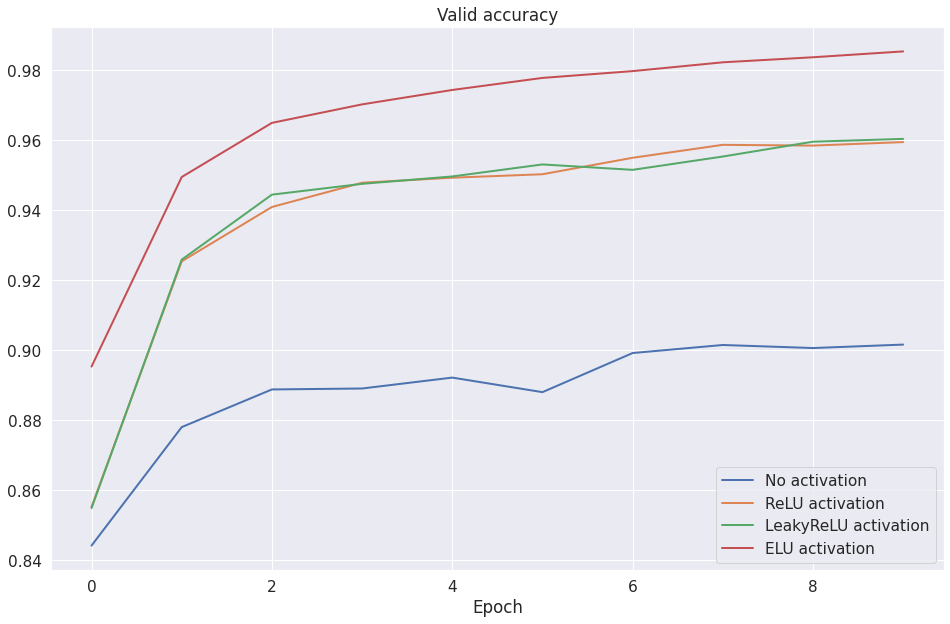

In [25]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:**

ELU

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [ ]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2021-11-04 08:51:54--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 144.76.208.75
Connecting to img.the-village.kz (img.the-village.kz)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg [following]
--2021-11-04 08:51:54--  https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village-kz.com (img.the-village-kz.com)... 144.76.208.75
Connecting to img.the-village-kz.com (img.the-village-kz.com)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K  --.-KB/s    in 0.02s   

2021-11-04 08:51:54 (1.92 MB/s) - ‘sample_photo.jpg’ saved [49337/

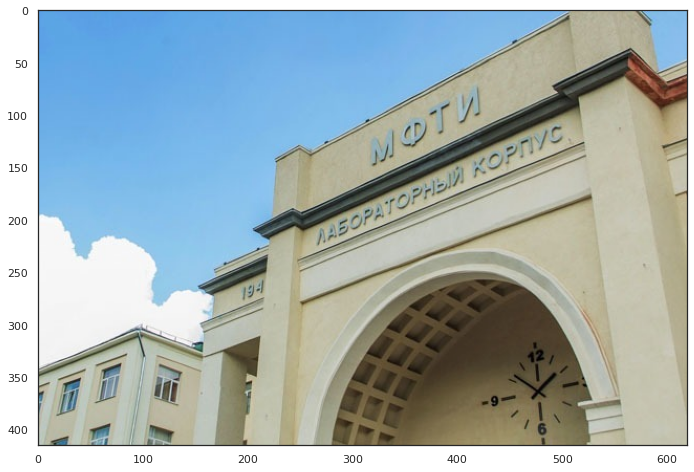

In [ ]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [ ]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, 1, 0],
    [0, -2, 0],
    [0, 1, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


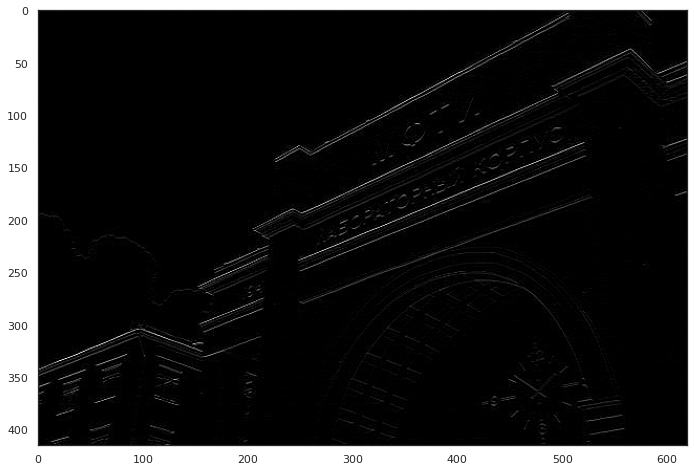

In [ ]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:**

А - Тождественное преобразование

Б - Выделение горизонтальных границ

В - Выделение вертикальных границ

Г - Выделение границ

Д - Увеличение резкости

Е - Размытие


### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [4]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [12]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2))   #YOUR CODE
        self.conv2 = nn.Conv2d(6, 16, 3)   #YOUR CODE
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2))    #YOUR CODE
        self.fc1 = nn.Linear(16 * 5 * 5, 120)   #YOUR CODE  
        self.fc2 = nn.Linear(120, 84)   #YOUR CODE
        self.fc3 = nn.Linear(84, 10)    #YOUR CODE

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        #x = nn.Flatten(x)
        #x = x.view(-1, int(x.nelement() / x.shape[0]))
        x = x.flatten(start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        #YOUR CODE. Apply layers created in __init__. 
        
        return x

In [13]:
model = LeNet().cpu()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [14]:
max_epochs = 10
accuracy = {"train": [], "valid": []}

for epoch in range(max_epochs):
  correct = 0
  epoch_correct = 0
  epoch_all = 0
  for k, dataloader in loaders.items():
    for x_batch, y_batch in dataloader:
      #x_batch.to(device)
      #y_batch.to(device)
      if k == "train":
        model.train()  
        optimizer = torch.optim.Adam(model.parameters())
        optimizer.zero_grad() 
        outp = model(x_batch)
        criterion = nn.CrossEntropyLoss()
        loss = criterion(outp, y_batch)
      else:
        model.eval()
        with torch.no_grad():
          outp = model(x_batch)
                
      preds = outp.argmax(-1)
      correct = (preds==y_batch).cpu().numpy().sum() 
      all = np.sum(list(y_batch.size())) 
      epoch_correct += correct.item()
      epoch_all += all
      if k == "train":
        loss = criterion(outp, y_batch)
        loss.backward() 
        optimizer.step() 

    if k == "train":
      print(f"Epoch: {epoch+1}")
    print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
    accuracy[k].append(epoch_correct/epoch_all)



Epoch: 1
Loader: train. Accuracy: 0.86755
Loader: valid. Accuracy: 0.8817142857142857
Epoch: 2
Loader: train. Accuracy: 0.9681333333333333
Loader: valid. Accuracy: 0.9693285714285714
Epoch: 3
Loader: train. Accuracy: 0.9772666666666666
Loader: valid. Accuracy: 0.9776285714285714
Epoch: 4
Loader: train. Accuracy: 0.9799833333333333
Loader: valid. Accuracy: 0.9803142857142857
Epoch: 5
Loader: train. Accuracy: 0.9796
Loader: valid. Accuracy: 0.9798428571428571
Epoch: 6
Loader: train. Accuracy: 0.9775166666666667
Loader: valid. Accuracy: 0.9774428571428572
Epoch: 7
Loader: train. Accuracy: 0.9752
Loader: valid. Accuracy: 0.9746714285714285
Epoch: 8
Loader: train. Accuracy: 0.9696333333333333
Loader: valid. Accuracy: 0.969
Epoch: 9
Loader: train. Accuracy: 0.9665
Loader: valid. Accuracy: 0.9668
Epoch: 10
Loader: train. Accuracy: 0.9649333333333333
Loader: valid. Accuracy: 0.9659714285714286


Два дня я пыталась посчитать эту хрень на гпу, получая ошибку вида "один тензор на гпу а другой на цпу". Прочитав кучу форумов, просмотрев несколько ноутбуков с похожим кодом, задолбав всех друзей, перепробовав все возможные варианты перемещения всего что вижу на куду, я забила и посчитала на цпу.

In [15]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

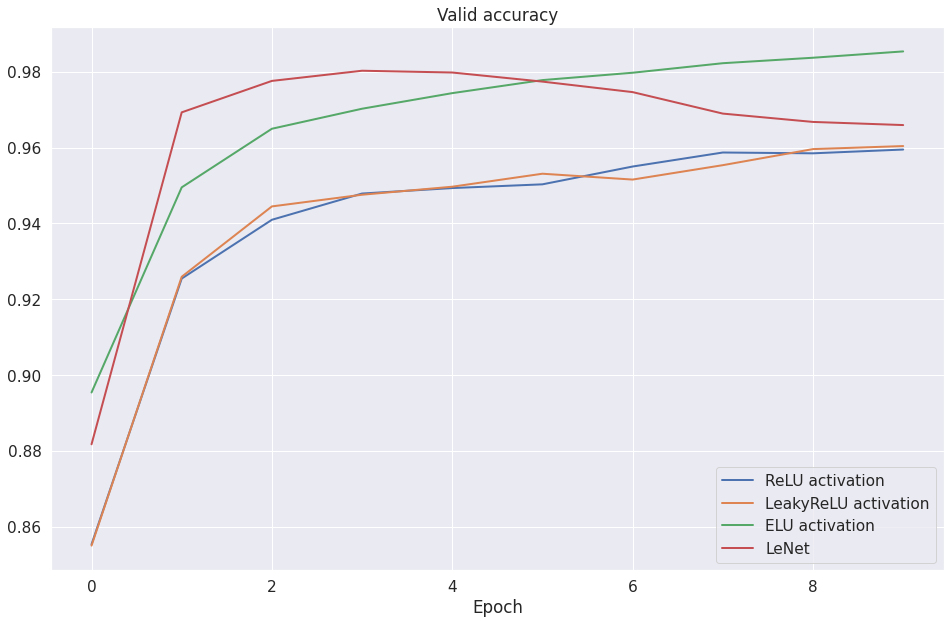

In [26]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:**

Epoch: 10

Loader: train. Accuracy: 0.96

Loader: valid. Accuracy: 0.97